
# Week 5 - Discovering Patterns: Clusters & Topics

In [1]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git


#All these packages need to be installed from pip
#These are all for the cluster detection
import sklearn
import sklearn.feature_extraction.text
import sklearn.pipeline
import sklearn.preprocessing
import sklearn.datasets
import sklearn.cluster
import sklearn.decomposition
import sklearn.metrics

import scipy #For hierarchical clustering and some visuals
#import scipy.cluster.hierarchy
import gensim#For topic modeling
import requests #For downloading our datasets
import numpy as np #for arrays
import pandas #gives us DataFrames
import matplotlib.pyplot as plt #For graphics
import matplotlib.cm #Still for graphics
import seaborn as sns #Makes the graphics look nicer

#This 'magic' command makes the plots work better
#in the notebook, don't use it outside of a notebook.
#Also you can ignore the warning, it
%matplotlib inline

import itertools
import json

import seaborn as sns
import pyLDAvis
from gensim.models import ldaseqmodel

unable to import 'smart_open.gcs', disabling that module


## <span style="color:red">*Pitch Your Project*</span>

<span style="color:red">In the three cells immediately following, describe **WHAT** you are planning to analyze for your final project (i.e., texts, contexts and the social game, world and actors you intend to learn about through your analysis) (<200 words), **WHY** you are going to do it (i.e., why would theory and/or the average person benefit from knowing the results of your investigation) (<200 words), and **HOW** you plan to investigate it (i.e., what are the approaches and operations you plan to perform, in sequence, to yield this insight) (<400 words).

## ***What?*** 
    
For my final project, I will investigate the epistemological space in psychology literature. Specifically, I want to investigate if researchers’ opinions on controversies in psychology are related to their researches.

Although grouped under a single domain name, topics and scopes of psychological researches have an amazing variation. Psychologists from different subsections and different schools of thought often have highly different opinions on controversial topics in the field. This project aims to find if such different opinions are related to how the epistemological space is formulated in psychological researches. Specifically, I want to explore if (1) does researchers sharing opinions on controversies write similar papers? (2) are there clustering of researchers who share the same opinions about a controversy in a specific domain (for example, most researchers in economical psychology might think the _homo economicus_ is an accurate model of human behavior).

To investigate whether these opinions in controversies affect the social game of publication in the psychology academic world (with researchers as actors), I will investigate the titles and abstracts of psychological articles through content analysis and link it to the survey data of the authors.

## ***Why?***

Science progresses through clashes of theories and opinions. Even if we put the “revolutionary science” framework of Kuhn aside, we can imagine that science will evolve faster when the academic environment is full of debates and researchers casting alternative views to other researchers’ works than when it consists of a uniform set of opinions and accept each other’s work blindly. When there are competing opinions and theoretical frameworks, researches that try to corroborate one view or falsify the others will accumulate to ultimately finding the strongest opinions and frameworks.

This project aims to find the relationship between researchers’ opinions on controversies and their position in the academic, epistemological space. If this project can show that people with similar opinions publish similar papers, it could signal the psychologists that they should try to communicate and collaborate with researchers with different thoughts. Moreover, if this project can identify a sub-domain in psychology in which the researchers are quite homogeneous to each other, it could serve as a suggestion to that domain that they could potentially benefit by introducing some fresh, “alien” perspectives. All in all, I believe this project could contribute to building a more diverse, healthy academic environment in psychology.

## ***How?***

The first step in executing this project will be to connect the datasets. Specifically, I have a dataset that has survey results for opinions on controversial topics in psychology and a dataset that contains a massive amount of abstracts and titles of psychological articles. I will start by locating articles that are authored by researchers who replied to the survey so I can connect the datasets. Also, I will concatenate the title and abstracts for the analysis.

After I connect the data, I want to calculate the similarities between the author’s articles based on textual properties. This similarity could be as simple as sharing a lot of words (for example, we can expect that word ‘memory’ will be shared among articles written by researchers in memory sciences), or it could be sharing high-level patterns such as topics generated from topic modeling (for example, perhaps there is a topic that can be seen as related to memory that will be prevalent in articles written by researchers in memory sciences), or it could be similarities based on vector space of articles (I do not have much experience with methods that will be discussed in weeks 6 and 7, but Professor Evans suggested that those materials will be useful). I will compare these similarities with the survey metrics of the authors to see if articles that were written by authors that have similar opinions also are similar to each other. These analyses will correspond to goal (1) mentioned in the *What?* Section.

Furthermore, I expect that I could identify distinct clusters of articles (and authors) based on titles and abstracts. I plan to inspect these clusters and see how homogenous authors within clusters are in terms of their stance in controversies in psychology. These analyses will correspond to goal (2) mentioned in the *What?* section.

Finally, this project is a subset of project Professor Evans is pursuing, and another RA on the project is working on drawing similarities based on citation networks. If citation network analysis is finished before the quarter, I will try to incorporate these results (e.g. comparing similarities based on citation analysis and similarities based on text analysis) as well.


## <span style="color:red">*Pitch Your Sample*</span>

<span style="color:red">In the cell immediately following, describe the rationale behind your proposed sample design for your final project. What is the social game, social work, or social actors you about whom you are seeking to make inferences? What are its virtues with respect to your research questions? What are its limitations? What are alternatives? What would be a reasonable path to "scale up" your sample for further analysis (i.e., high-profile publication) beyond this class? (<300 words).

## ***Which (words)?***

There are two sources of data to this project – surveys and articles. For the survey, the sample design was to mail as many psychology authors as possible using metadata from Web of Science and use all the replies. The specifics and visualization of the survey results are in [here]( http://academic-priors.herokuapp.com/).

My current sample design for articles is to try to build as complete sample as possible using the survey data. Specifically, I have collected abstracts and titles of all articles that are tagged as “psychology” from Web of Science during 1985-2015. I will use the name and e-mail address from survey data to find all articles that are written by survey respondents and link them to the survey data for further analysis.

The virtue of this data to my research question is that this is directly related to the social game and social actor I am interested in. The social game I am interested in is the epistemological space in psychology literature, and the article texts are directly related to this social game. The social actors I am interested in are the academics in psychology, and the survey data is directly answered by the academics in psychology.

The limitation of this sample is that Web of Science relatively has sparse data on years before the 2000s, so the sample is smaller in those periods. An alternative could be using data from a database that are specifically devoted to storing information about psychology literature – PsycNet. Professor Evans and I are contacting them to see if we can get their data. Combining data from two data sources could also be a good strategy in trying to “scale up” the sample for further analysis. 

# Flat Clustering with $K$-means

In [71]:
def plotSilhouette(n_clusters, X):
    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize = (15,5))
    
    ax1.set_xlim([-0.1, 1])
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])
    clusterer = sklearn.cluster.KMeans(n_clusters=n_clusters, random_state=10)
    cluster_labels = clusterer.fit_predict(X)
    
    silhouette_avg = sklearn.metrics.silhouette_score(X, cluster_labels)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = sklearn.metrics.silhouette_samples(X, cluster_labels)

    y_lower = 10
    
    for i in range(n_clusters):
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i
        cmap = matplotlib.cm.get_cmap("nipy_spectral")
        color = cmap(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        y_lower = y_upper + 10
    
    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    cmap = matplotlib.cm.get_cmap("nipy_spectral")
    colors = cmap(float(i) / n_clusters)
    ax2.scatter(reduced_data[:, 0], reduced_data[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors)

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    projected_centers = pca.transform(centers)
    # Draw white circles at cluster centers
    ax2.scatter(projected_centers[:, 0], projected_centers[:, 1],
                marker='o', c="white", alpha=1, s=200)

    for i, c in enumerate(projected_centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1, s=50)

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("PC 1")
    ax2.set_ylabel("PC 2")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')
    plt.show()
    print("For n_clusters = {}, The average silhouette_score is : {:.3f}".format(n_clusters, silhouette_avg))

## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that construct features and cluster your documents using K-means and a variety of cluster numbers. Interrogate the cluster contents in terms of both documents and features. Identify the "optimal" cluster number with Silhouette analysis. Plot clusters and features after reducing with PCA. What does this cluster structure reveal about the organization of documents in your corpora? 

For the dataset, I will use a subset of data for all psychologlical articles in web of science I had collected so far. The data spans from 1985 to 2015.

First, I will load the data:

In [4]:
wos_df = pandas.read_csv('../../Final Project/clean_data_0512.csv')
wos_df.head()

,wos_id,abstract,title,pubyear,journal,subject,text
0,WOS:000209363400003,The construction and use of a test of syntacti...,The Active-Passive Test: An Age-Referenced Cli...,1985,DEVELOPMENTAL NEUROPSYCHOLOGY,"['Psychology|Developmental', ' Psychology|Expe...",The Active-Passive Test: An Age-Referenced Cli...
1,WOS:000207981700001,Virtually all research on mnemonics has been p...,Cross-Cultural Applications Of Yodai Mnemonics...,1985,EDUCATIONAL PSYCHOLOGIST,"['Psychology|Educational', ' Psychology']",Cross-Cultural Applications Of Yodai Mnemonics...
2,WOS:000207982000002,Computers are classically viewed as amplifiers...,Beyond Amplification: Using The Computer To Re...,1985,EDUCATIONAL PSYCHOLOGIST,"['Psychology|Educational', ' Psychology']",Beyond Amplification: Using The Computer To Re...
3,WOS:000209363500005,Performance on measures of perceptual and late...,Lateralization In Gifted Children,1985,DEVELOPMENTAL NEUROPSYCHOLOGY,"['Psychology|Developmental', ' Psychology|Expe...",Lateralization In Gifted Children Performance ...
4,WOS:000209363500001,The literature on intellectual and academic ou...,Intellectual And Academic Outcome Following Cl...,1985,DEVELOPMENTAL NEUROPSYCHOLOGY,"['Psychology|Developmental', ' Psychology|Expe...",Intellectual And Academic Outcome Following Cl...


Let's see the data size:

In [28]:
wos_df.shape

(579338, 7)

It is a little too large for this notebook. Let's try to subset only one year - 2015:

In [56]:
wos_df_ = wos_df[wos_df['pubyear'] == 2015]

In [57]:
wos_df_.shape

(35557, 7)

The data still is too large (k-means did not produce a result for 4+ hours when I tried with this data initialy). I will subset 1,000 articles randomly:

In [59]:
np.random.seed(512)
idx = np.random.choice(wos_df_.shape[0], size=5000, replace=False)
wos_df_ = wos_df_.iloc[idx, :].copy()

Now let's create TF-IDF vectors to feed into the k-means algorithm:

In [62]:
#initialize
wosTFVectorizer = sklearn.feature_extraction.text.TfidfVectorizer(max_df=0.5, max_features=1000, min_df=3, stop_words='english', norm='l2')
#train
wosTFVects = wosTFVectorizer.fit_transform(wos_df_['text'])
print(wosTFVects.shape)

(5000, 1000)


Sanity checking by pulling out some words:

In [63]:
list(wosTFVectorizer.vocabulary_.keys())[:10]

['information',
 'perception',
 'visual',
 'auditory',
 'driving',
 'versus',
 'does',
 'impact',
 'ability',
 'perceptual']

It looks like there are words related to psychology!

Now I will do Silhouette analysis and plot results. I will start with 10 clusters. Since there is no way 5000 articles could be boiled down to 10 clusters, I expect the Silhouette score to be low.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


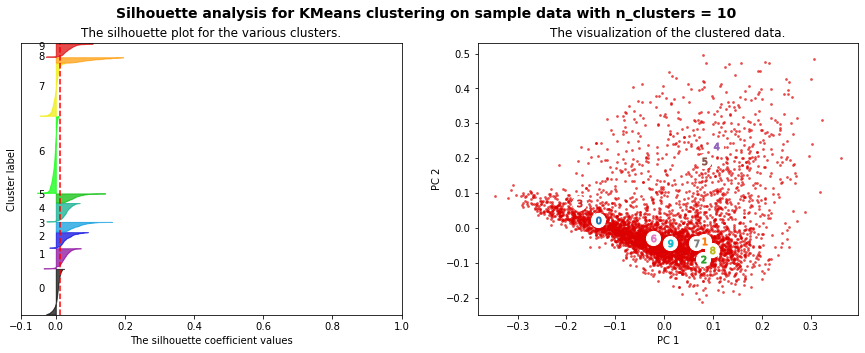

For n_clusters = 10, The average silhouette_score is : 0.013


In [73]:
plotSilhouette(10, X)

Indeed, the average silhouette score is only 0.013. Let's try with 100 clusters:

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


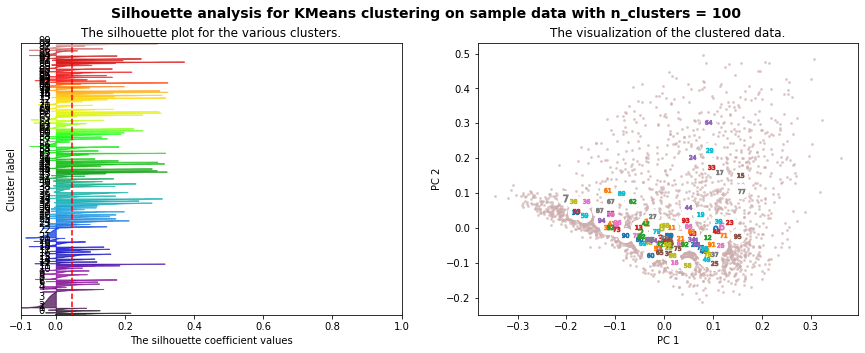

For n_clusters = 100, The average silhouette_score is : 0.048


In [74]:
plotSilhouette(100, X)

A bit better! Now I will try 500 clusters: 

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


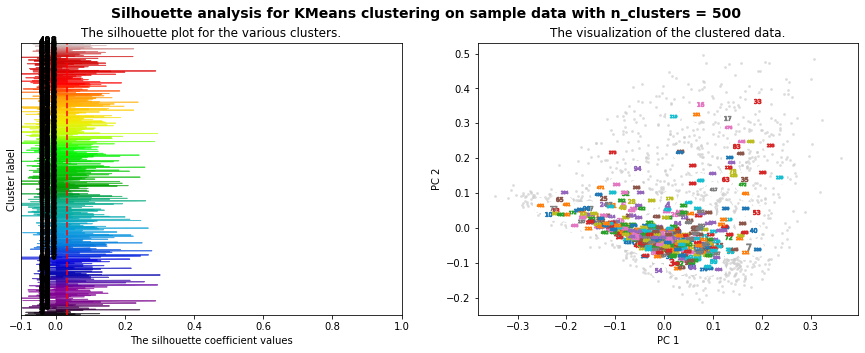

For n_clusters = 500, The average silhouette_score is : 0.033


In [76]:
plotSilhouette(500, X)

The average Silhouette score got lower, so I will try an intermediate number: 250.

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


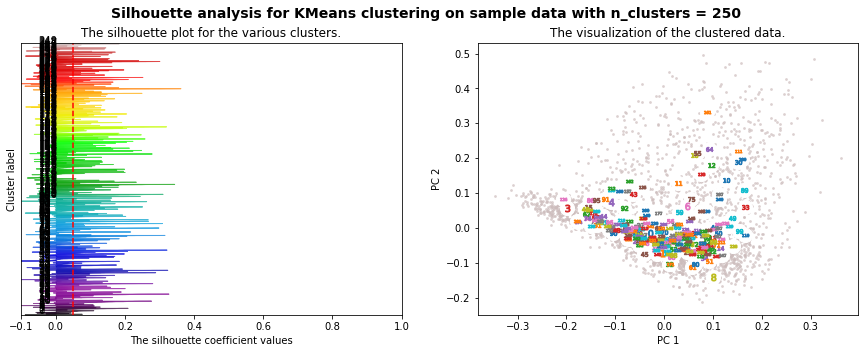

For n_clusters = 250, The average silhouette_score is : 0.049


In [77]:
plotSilhouette(250, X)

The score is slightly higher than when I tried 100 clusters, but it looks equivalent. I suppose the ideal cluster number will be somewhere between 100-500 clusters, I will just go with 100 clusters for shorter runtime in this notebook.

Intializing k-means and fitting the TF-IDF vectors:

In [79]:
numClusters = 100
km = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')
km.fit(wosTFVects)

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
       n_clusters=100, n_init=10, n_jobs=None, precompute_distances='auto',
       random_state=None, tol=0.0001, verbose=0)

I will append the predicted labels similar to the original notebook.

In [80]:
wos_df_['kmeans_predictions'] = km.labels_
wos_df_.head()

,wos_id,abstract,title,pubyear,journal,subject,text,kmeans_predictions
561874,WOS:000364972100006,Visual and auditory inputs vary in complexity....,Information Theoretic Complexity Affects Multi...,2015,VISUAL COGNITION,"['Psychology|Experimental', ' Psychology']",Information Theoretic Complexity Affects Multi...,33
568360,WOS:000353434100003,Purpose. - The seclusion is a tool of psychiat...,The Practice Of Seclusion Among Patients Hospi...,2015,ANNALES MEDICO-PSYCHOLOGIQUES,"['Psychology|Multidisciplinary', ' Psychology']",The Practice Of Seclusion Among Patients Hospi...,5
569371,WOS:000365538600017,An extensive literature shows that greater lef...,Asymmetric Frontal Cortical Activity Predicts ...,2015,SOCIAL COGNITIVE AND AFFECTIVE NEUROSCIENCE,"['Psychology|Experimental', ' Psychology']",Asymmetric Frontal Cortical Activity Predicts ...,8
566473,WOS:000359502600001,"Within the new DSM-5, the currently differenti...",Autism Spectrum Disorder And Dsm-5: Spectrum O...,2015,PRAXIS DER KINDERPSYCHOLOGIE UND KINDERPSYCHIA...,"['Psychology|Developmental', ' Psychology']",Autism Spectrum Disorder And Dsm-5: Spectrum O...,74
549316,WOS:000351400600003,Euthanasia is legal in Belgium if due care cri...,"Attitudes Of Belgian Students Of Medicine, Phi...",2015,DEATH STUDIES,"['Psychology|Multidisciplinary', ' Psychology']","Attitudes Of Belgian Students Of Medicine, Phi...",92


Now I will visualize the clusering with first two Principle Components:

In [82]:
# fitting PCA
PCA = sklearn.decomposition.PCA
pca = PCA(n_components = 2).fit(wosTFVects.toarray())
reduced_data = pca.transform(wosTFVects.toarray())

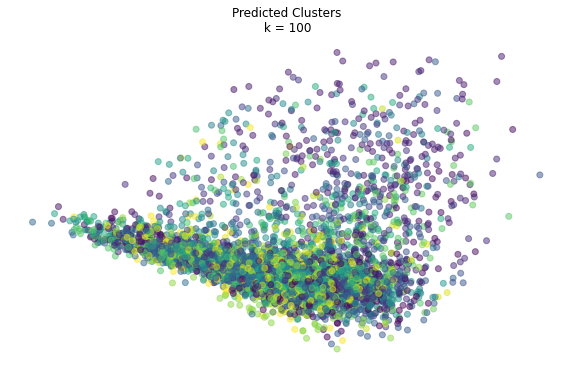

In [85]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], c = wos_df_['kmeans_predictions'], alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 100')
plt.show()

It is really hard to interpret the 100 clusters in this visualization!

I will fit k-means with 4 clusters for more clear visualization:

In [86]:
numClusters = 4
km = sklearn.cluster.KMeans(n_clusters=numClusters, init='k-means++')
km.fit(wosTFVects)
wos_df_['kmeans_predictions_4'] = km.labels_
colordict = {
0: 'red',
1: 'orange',
2: 'green',
3: 'blue',
    }
colors = [colordict[c] for c in wos_df_['kmeans_predictions_4']]

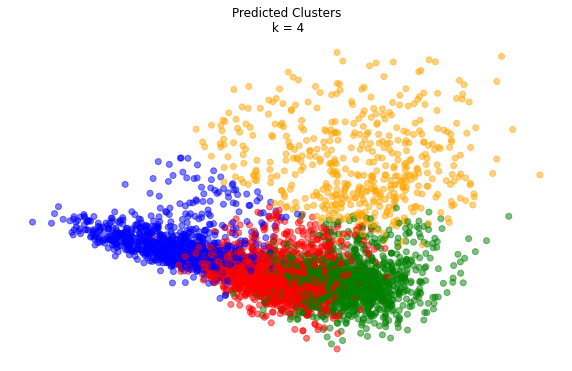

In [88]:
fig = plt.figure(figsize = (10,6))
ax = fig.add_subplot(111)
ax.set_frame_on(False)
plt.scatter(reduced_data[:, 0], reduced_data[:, 1], color = colors, alpha = 0.5)
plt.xticks(())
plt.yticks(())
plt.title('Predicted Clusters\n k = 4')
plt.show()

This is more interpretable! We can see that the orange cluster (topic 1) seems to be a bit more sparsely populated in the PC dimensions.

Although we saw that 4 is far from optimal number, I will just inspect these clusters for interpretation's sake. Let's look at the top 10 terms for each cluster, analogous to the original notebook.

In [90]:
terms = wosTFVectorizer.get_feature_names()
print("Top terms per cluster:")
order_centroids = km.cluster_centers_.argsort()[:4, ::-1]
for i in range(numClusters):
    print("Cluster %d:" % i)
    for ind in order_centroids[i, :10]:
        print(' %s' % terms[ind])
    print('\n')

Top terms per cluster:
Cluster 0:
 social
 self
 research
 students
 model
 behavior
 results
 data
 work
 learning


Cluster 1:
 children
 child
 asd
 adhd
 parents
 autism
 parent
 mothers
 problems
 disorder


Cluster 2:
 treatment
 sexual
 patients
 health
 symptoms
 women
 use
 risk
 depression
 alcohol


Cluster 3:
 memory
 task
 visual
 processing
 participants
 performance
 stimuli
 cognitive
 effect
 information




I think the top words indexes the theme of each cluster quite intuitively. Cluster 0 could be labeled "Social and Personality Psychology", since it's top words are "social" and "self". "student" also stands out, and this makes sense - since social psych usually requires much larger n than other domains, student participants are more heaviliy employed in these researches. Cluster 1 is could be labeled "Developmental disorder". Words like "children", "chile" is on top along with names of developmental disorders like "autism", "asd" (Autism Spectrum Disorder) and "adhd"(Attention deficit hyperactivity disorder) shows up. Cluster 2 seems to be related to other mental health problems. Words like "treatment", "patients", "health", "symptoms", "risk", "depression", and "alcohol" seems to be the top terms. I guess the "sexual" and "woman" terms came in because usually there is sexual difference in probability of onset of symptoms. Finally, cluster 3 seems to be broadly related to the realm of cognitive psychology, since virtually all terms are important keywords in the field.

Let's see how many articles were classified as such:

In [209]:
wos_df_['kmeans_predictions_4'].value_counts()

0    2091
2    1325
3    1091
1     493
Name: kmeans_predictions_4, dtype: int64

It looks like we have a lot of articles on social/personality psychology and very few articles about cognitive psychology in this data subset! This might be a weird consequence of sampling (we only took about 15% of the data!) or it could be representative of the overall dataset (we randomly sampled!). Also, the proportion might differ as we take more optimal number of clusters.

One thing we can be sure of is that these sampling do give us quite intuitive label names for each. This is promising as I think about applying this to larger data for the final project!

# Hierarchical Clustering with Wald's Method

## <span style="color:red">*Exercise 2*</span>

<span style="color:red">Construct cells immediately below this that hierarchically cluster your documents using two approaches, and visualize them with a tree. Interrogate the recursive cluster contents in terms of both documents and closenesses. What does this nested cluster structure reveal about the organization of documents in your sampled corpora? Moreover, if they do worse than kmeans (as above), why do you think this is the case (hint: using metrics if you have ground truth or silhouette if you do not)? 

<span style="color:red">***Stretch***: Attempt using different distances into your clustering algorithms. (How) do they change the arrangement of clusters?

I am using the same dataset form exercise 1.

First I will create a word cooccurance matrix for using Wald's method:

In [162]:
wosCoocMat = wosTFVects * wosTFVects.T
#set the diagonal to 0 since we don't care how similar texts are to themselves
wosCoocMat.setdiag(0)

Applying Wald's method and storing them in a matrix:

In [163]:
linkage_matrix = scipy.cluster.hierarchy.ward(wosCoocMat.toarray())
linkage_matrix[:10]

C:\Users\nousl\Anaconda3\envs\macs60000\lib\site-packages\scipy\cluster\hierarchy.py:830: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='ward', metric='euclidean')


array([[1.28100000e+03, 1.74400000e+03, 1.43392521e+00, 2.00000000e+00],
       [2.20000000e+02, 2.05500000e+03, 1.70394996e+00, 2.00000000e+00],
       [1.84800000e+03, 4.52000000e+03, 1.75265741e+00, 2.00000000e+00],
       [1.30100000e+03, 1.96900000e+03, 1.83680266e+00, 2.00000000e+00],
       [6.87000000e+02, 2.06800000e+03, 1.85599591e+00, 2.00000000e+00],
       [2.25700000e+03, 4.95800000e+03, 1.87162360e+00, 2.00000000e+00],
       [4.41000000e+02, 3.48900000e+03, 1.88068846e+00, 2.00000000e+00],
       [3.32200000e+03, 3.65000000e+03, 1.89034200e+00, 2.00000000e+00],
       [5.06000000e+02, 2.97700000e+03, 1.89441822e+00, 2.00000000e+00],
       [1.42000000e+03, 2.27400000e+03, 1.89550042e+00, 2.00000000e+00]])

Let's visualize the entire tree:

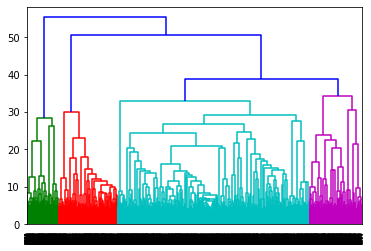

In [164]:
dendDat = scipy.cluster.hierarchy.dendrogram(linkage_matrix, get_leaves=True)

This is quite messy, so I will plot again with p=100.

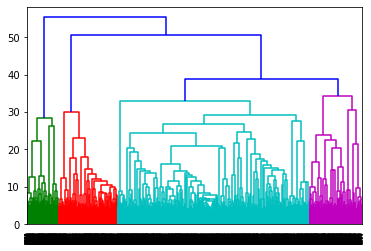

In [173]:
# storing the result to tmp so only plot appears
tmp = scipy.cluster.hierarchy.dendrogram(linkage_matrix, p=100, truncate_mode='level', get_leaves=True)
del tmp

Not much difference! I will try again with p=4.

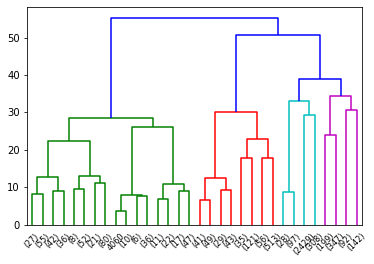

In [165]:
# storing the result to tmp so only plot appears
tmp = scipy.cluster.hierarchy.dendrogram(linkage_matrix, p=4, truncate_mode='level', get_leaves=True)
del tmp

We can see that while some leaves have less than 100 articles, some leaves have more than 2000 articles attached to it. Same with k-means, it looks like we need more depth to make this work.

It looks like one cluster (one shown in green) is quite distinct from the other clusters. Perhaps there are fields of psychology that is really far from other fields in psychology, at least in TF-IDF vecotors. I am not sure how to inspect that cluster further, but my guess is that that field will be developmental disorders.

Let's label the articles using `scipy.cluster.hierarchy.fcluster` and examine some titles in each cluster.

In [169]:
hierarchicalClusters = scipy.cluster.hierarchy.fcluster(linkage_matrix, 4, 'maxclust')
hierarchicalClusters_100 = scipy.cluster.hierarchy.fcluster(linkage_matrix, 100, 'maxclust')
wos_df_['wald_predictions_4'] = hierarchicalClusters
wos_df_['wald_predictions'] = hierarchicalClusters_100
wos_df_.head()

cluster 1:

In [222]:
list(wos_df_[wos_df_['wald_predictions_4'] == 1].iloc[:10, 2])

['Autism Spectrum Disorder And Dsm-5: Spectrum Or Cluster?',
 'Arithmetic Fact Retrieval Are There Differences Between Children With Developmental Dyscalculia And Those With Mathematical Difficulties?',
 "Parenting Interventions In Tic Disorders: An Exploration Of Parents' Perspectives",
 'Preliminary Normative Data On The Penn State University Symbol Cancellation Task With Nonconcussed Adolescents',
 'Developmental Trajectories Of Aggression, Prosocial Behavior, And Social-Cognitive Problem Solving In Emerging Adolescents With Clinically Elevated Attention-Deficit/Hyperactivity Disorder Symptoms',
 'A Systematic Review Of Research On Children Of Alcoholics: Their Inherent Resilience And Vulnerability',
 'Childhood Neurodevelopmental Problems And Adolescent Bully Victimization: Population-Based, Prospective Twin Study In Sweden',
 'Lexical Processing Deficits In Children With Developmental Language Disorder: An Event-Related Potentials Study',
 "The Impact Of Various Parental Mental Di

cluster 2:

In [223]:
list(wos_df_[wos_df_['wald_predictions_4'] == 2].iloc[:10, 2])

['Information Theoretic Complexity Affects Multisensory Perception',
 'Asymmetric Frontal Cortical Activity Predicts Effort Expenditure For Reward',
 'Attentional And Emotional Prioritization Of The Sounds Occurring Outside The Visual Field',
 'The Role Of Orthographic Neighborhood Size Effects In Chinese Word Recognition',
 'Influences Of Appearance-Behaviour Congruity On Memory And Social Judgements',
 'Trends In Classroom Observation Scores',
 'Numerosity Processing Is Context Driven Even In The Subitizing Range: An Fmri Study',
 'Basic Auditory Processing And Sensitivity To Prosodic Structure In Children With Specific Language Impairments: A New Look At A Perceptual Hypothesis',
 'Two Routes To The Same Action: An Action Repetition Priming Study',
 'Attentional Priming In Hierarchical Visual Patterns: Effects Of Treated Level, Absolute Size And Consistency Stimulate.']

cluster 3:

In [224]:
list(wos_df_[wos_df_['wald_predictions_4'] == 3].iloc[:10, 2])

['Attitudes Of Belgian Students Of Medicine, Philosophy, And Law Toward Euthanasia And The Conditions For Its Acceptance',
 'On The Effectiveness Of The Prevention Program Jobfit: A Comparison Of Different Class Levels',
 'Reciprocal Associations Among Self-Focused Attention, Self-Acceptance, And Empathy: A Two-Wave Panel Study',
 'Making Sense In And Of The Asexual Community: Navigating Relationships And Identities In A Context Of Resistance',
 'The Effect Of The "Evoking Freedom" Technique On An Unusual And Disturbing Request',
 'Generational Forgiveness And Historical Injustices: Perspectives Of Descendants Of Victims Of Apartheid-Era Gross Human Rights Violations In South Africa',
 'Profiles Of Medicinal Cannabis Patients Attending Compassion Centers In Rhode Island',
 'Towards A Mechanistic Understanding Of The Effects Of Body Posture On Facial Emotion Categorization',
 'Latent Profile Analysis Of The Physical Self-Description Among Chinese Adolescents',
 'Analysis Of Landmine Fat

cluster 4:

In [221]:
list(wos_df_[wos_df_['wald_predictions_4'] == 4].iloc[:10, 2])

['The Practice Of Seclusion Among Patients Hospitalized Under Constraint In A Psychiatric Emergency Unit. About 266 Cases',
 'Risk And Protective Factors For The Development Of Depressive Symptoms In Children And Adolescents: Results Of The Longitudinal Bella Study',
 'Use Of Multiple Sex Venues And Prevalence Of Hiv Risk Behavior: Identifying High-Risk Men Who Have Sex With Men',
 'Psychotherapists As Gatekeepers: An Evidence-Based Case Study Highlighting The Role And Process Of Letter Writing For Transgender Clients',
 'Emdr Therapy For Ptsd After Motor Vehicle Accidents: Meta-Analytic Evidence For Specific Treatment',
 'Sexual Assault Related Distress And Drinking: The Influence Of Daily Reports Of Social Support And Coping Control',
 'The "Empty Vessel" Physician: Physicians\' Instrumentality Makes Them Seem Personally Empty',
 'The Safety Program: A Treatment-Development Trial Of A Cognitive-Behavioral Family Treatment For Adolescent Suicide Attempters',
 'Explaining The Frequency

Guessing from the titles, I think these clusters are the same with k-means clusters (with 4 clusters) with just different label number. Cluster 1 seems to be developmental disorder, cluster 2 seems to be cognitive psychology, cluster 3 seems to be social/personality psychology and cluster 4 seems to be other mental health problems.

From this, I guess that there are relatively distinct clusters in the articles, and we can separate them from various clustering algorithms. Let's see how much these predictions match the prediction from k-means by the corresponding category I just mentioned:

In [227]:
print('cluster 1:')
print(wos_df_[(wos_df_['wald_predictions_4'] == 1) & (wos_df_['kmeans_predictions_4'] == 1)].shape[0] / wos_df_[(wos_df_['wald_predictions_4'] == 1)].shape[0])
print('cluster 2:')
print(wos_df_[(wos_df_['wald_predictions_4'] == 2) & (wos_df_['kmeans_predictions_4'] == 3)].shape[0] / wos_df_[(wos_df_['wald_predictions_4'] == 2)].shape[0])
print('cluster 3:')
print(wos_df_[(wos_df_['wald_predictions_4'] == 3) & (wos_df_['kmeans_predictions_4'] == 0)].shape[0] / wos_df_[(wos_df_['wald_predictions_4'] == 3)].shape[0])
print('cluster 4:')
print(wos_df_[(wos_df_['wald_predictions_4'] == 4) & (wos_df_['kmeans_predictions_4'] == 2)].shape[0] / wos_df_[(wos_df_['wald_predictions_4'] == 4)].shape[0])

cluster 1:
0.8301486199575372
cluster 2:
0.8162344983089064
cluster 3:
0.6425576519916143
cluster 4:
0.8217948717948718


It seems like the two algorithm agree with each other quite substantively! This further supports the notion that the articles are quite distinct and different clustering algorithm will produce similar results.

Finally, let's calculate the Silhouette score for 100 clusters:

In [171]:
X = wosTFVects.toarray()
sklearn.metrics.silhouette_score(X, wos_df_['wald_predictions'])

0.027194794720596202

It is quite less than that of k-means (0.048)! Perhaps k-means are better fit for this data than hierarchial clustering.

## Stretch

I will try median distance with `scipy.cluster.hierarchy.median`.

In [230]:
linkage_matrix = scipy.cluster.hierarchy.median(wosCoocMat.toarray())

C:\Users\nousl\Anaconda3\envs\macs60000\lib\site-packages\scipy\cluster\hierarchy.py:731: ClusterWarning: scipy.cluster: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  return linkage(y, method='median', metric='euclidean')


Let's plot with p=100:

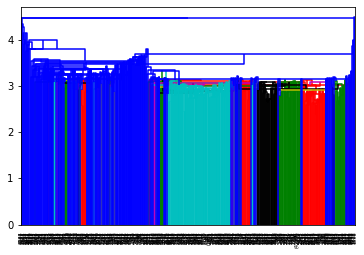

In [231]:
tmp = scipy.cluster.hierarchy.dendrogram(linkage_matrix, p=100, truncate_mode='level', get_leaves=True)
del tmp

Yikes! this makes me feel afraid of computers. let's try with p=4.

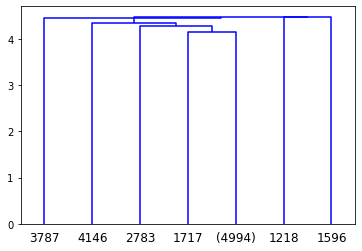

In [232]:
tmp = scipy.cluster.hierarchy.dendrogram(linkage_matrix, p=4, truncate_mode='level', get_leaves=True)
del tmp

Using median distance seems to be generating quite distinct result form results from Wald's method. Wald's method clearly suggested 4 clusters, while using median distance seems to be generating much more clusters that are nested deeply within each other.

# Gensim

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that topic model documents related to your anticipated final project. Interrogate and visually plot (e.g., as a bar graph?) the topic-word loadings and the document-topic loadings. What does this topic structure reveal about the distribution of contents across your documents? Systematically vary the $\alpha$, $\eta$, and topic number of the model for your text and describe in detail whether and how these changes led to distinctive outcomes, visible to you as analyst.  

<span style="color:red">**Stretch**: Cluster your documents, but instead of using words alone, use their topic loadings as an additional set of features. Do these topic loadings increase the apparent semantic coherence of your clusters?</span> 

I will be using the same dataset from exercise 1 and 2.

First tokenizing & normalizing:

In [175]:
#Apply our functions
wos_df_['tokenized_text'] = wos_df_['text'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
wos_df_['normalized_tokens'] = wos_df_['tokenized_text'].apply(lambda x: lucem_illud_2020.normalizeTokens(x))

Dropping articles without any valid tokens (this drops 0):

In [176]:
def dropMissing(wordLst, vocab):
    return [w for w in wordLst if w in vocab]

wos_df_['reduced_tokens'] = wos_df_['normalized_tokens'].apply(lambda x: dropMissing(x, wosTFVectorizer.vocabulary_.keys()))

Making dictionary and corpus:

In [178]:
dictionary = gensim.corpora.Dictionary(wos_df_['reduced_tokens'])
corpus = [dictionary.doc2bow(text) for text in wos_df_['reduced_tokens']]

Serializing the corpus as a file and loading it:

In [181]:
gensim.corpora.MmCorpus.serialize('wos_small.mm', corpus)
wosmm = gensim.corpora.MmCorpus('wos_small.mm')

Now let's run LDA! Although the ideal number of topics are likely to be way bigger than 4, I will just try 4 topics here for interpretability.

In [182]:
woslda = gensim.models.ldamodel.LdaModel(corpus=wosmm, id2word=dictionary, num_topics=4, alpha='auto', eta='auto')

Let's look at topic-word loading first! Let's see the top 10 words from each topics:

In [192]:
ldaDF = pandas.DataFrame({
        'name' : wos_df_['title'],
        'topics' : [woslda[dictionary.doc2bow(l)] for l in wos_df_['reduced_tokens']]
    })

In [204]:
topicsDict = {}
for topicNum in range(woslda.num_topics):
    topicWords = [w for w, p in woslda.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict)
wordRanksDF

,Topic_0,Topic_1,Topic_2,Topic_3
0,child,result,effect,child
1,group,self,process,sexual
2,disorder,high,participant,behavior
3,result,effect,social,high
4,control,relationship,result,student
5,adolescent,social,model,test
6,parent,stress,self,report
7,treatment,level,analysis,use
8,symptom,behavior,patient,health
9,anxiety,examine,response,school


This word-topic loading is much less interpretable than the previous two clusters we saw before. Roughly, I think topic_0 could be related to developmental disorder, social/personality psychology is split into topic_1 and topic_2, and topic_3 seems to be specifically dealing with developmental psychology. The cognitive psychology cluster, seen in previous two clusters, disappeared here - this might be related to relatively small number of articles that were classified as cognitive psychology.

Overall, I think more topics are needed to use topic modeling more properly.

Now let's inspect the document-topic loadings!

I will use the codes from the original notebook to build a dataframe containing the title of articles and the corresponding topics:

In [193]:
#Dict to temporally hold the probabilities
topicsProbDict = {i : [0] * len(ldaDF) for i in range(woslda.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(woslda.num_topics):
    ldaDF['topic_{}'.format(topicNum)] = topicsProbDict[topicNum]

ldaDF[1::100]

,name,topics,topic_0,topic_1,topic_2,topic_3
568360,The Practice Of Seclusion Among Patients Hospi...,"[(0, 0.799833), (3, 0.19604036)]",0.799833,0.000000,0.000000,0.196040
555850,Perception Matters For Clinical Perfectionism ...,"[(0, 0.20777401), (1, 0.7880167)]",0.207774,0.788017,0.000000,0.000000
553113,A Framework For Studying Mechanisms Underlying...,"[(2, 0.5958261), (3, 0.39699)]",0.000000,0.000000,0.595826,0.396990
577450,The Social Psychology Of False Confessions,"[(2, 0.6861256), (3, 0.30251577)]",0.000000,0.000000,0.686126,0.302516
565588,Causal Conceptions In Social Explanation And M...,"[(1, 0.65725553), (2, 0.335124)]",0.000000,0.657256,0.335124,0.000000
553500,Common Rather Than Unique Aspects Of Repetitiv...,"[(0, 0.75651723), (2, 0.23823081)]",0.756517,0.000000,0.238231,0.000000
568647,The Effect Of Functionality- And Aesthetic-Foc...,"[(1, 0.067902125), (2, 0.9280305)]",0.000000,0.067902,0.928030,0.000000
544635,The Efficacy Of Computerized Alcohol Intervent...,"[(0, 0.553865), (3, 0.4419766)]",0.553865,0.000000,0.000000,0.441977
550336,The Calming Effect Of Maternal Carrying In Dif...,"[(0, 0.3358807), (1, 0.3824268), (2, 0.27986416)]",0.335881,0.382427,0.279864,0.000000
575521,Social Consequences Of Academic Teaming In Mid...,"[(1, 0.12555732), (3, 0.8686371)]",0.000000,0.125557,0.000000,0.868637


Now let's visualize topics of first 10 articles using stacked bar chart:

In [196]:
ldaDFV = ldaDF[:10][['topic_%d' %x for x in range(4)]]
ldaDFVisN = ldaDF[:10][['name']]
ldaDFVis = ldaDFV.to_numpy()
ldaDFVisNames = ldaDFVisN.to_numpy()
ldaDFV

,topic_0,topic_1,topic_2,topic_3
561874,0.000000,0.0,0.986086,0.000000
568360,0.799833,0.0,0.000000,0.196040
569371,0.000000,0.0,0.887942,0.107250
566473,0.989263,0.0,0.000000,0.000000
549316,0.000000,0.0,0.536707,0.446400
550392,0.000000,0.0,0.000000,0.983577
569595,0.216382,0.0,0.000000,0.776544
577165,0.988499,0.0,0.000000,0.000000
566397,0.000000,0.0,0.992762,0.000000
558574,0.664971,0.0,0.000000,0.331850


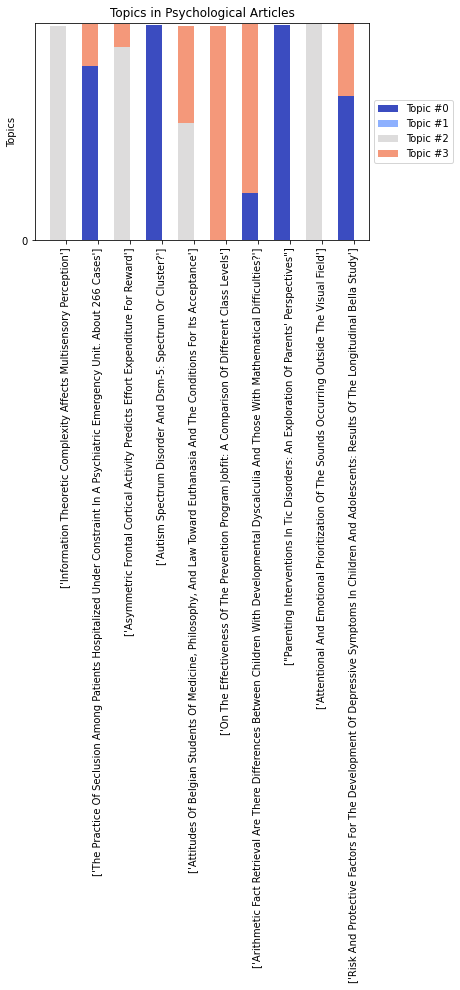

In [236]:
N = 10
ind = np.arange(N)
K = woslda.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Psychological Articles')
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

It looks like topic_1 somehow had 0 appearance in the first 10 documents.

Now let's try to visualize with a heatmap:

C:\Users\nousl\Anaconda3\envs\macs60000\lib\site-packages\ipykernel_launcher.py:13: UserWarning: Tight layout not applied. The left and right margins cannot be made large enough to accommodate all axes decorations. 
  del sys.path[0]


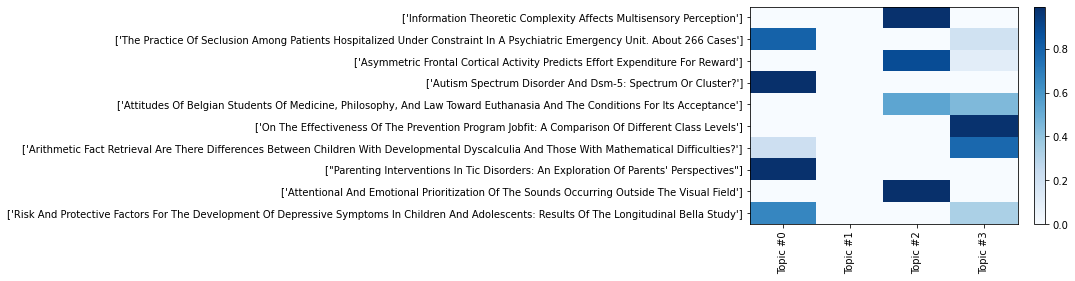

In [199]:
plt.pcolor(ldaDFVis, norm=None, cmap='Blues')
plt.yticks(np.arange(ldaDFVis.shape[0])+0.5, ldaDFVisNames);
plt.xticks(np.arange(ldaDFVis.shape[1])+0.5, topic_labels);

# flip the y-axis so the texts are in the order we anticipate (Austen first, then Brontë)
plt.gca().invert_yaxis()

# rotate the ticks on the x-axis
plt.xticks(rotation=90)

# add a legend
plt.colorbar(cmap='Blues')
plt.tight_layout()  # fixes margins
plt.show()

Now let's try to vary the parameters a little bit to see what are there effects.

First let's try seeing what happens if we set `alpha`='asymmetric' instead of 'auto':

In [233]:
woslda0 = gensim.models.ldamodel.LdaModel(corpus=wosmm, id2word=dictionary, num_topics=4, alpha='asymmetric', eta='auto')

Let's look at topic-word loading:

In [234]:
topicsDict0 = {}
for topicNum in range(woslda0.num_topics):
    topicWords0 = [w for w, p in woslda0.show_topic(topicNum)]
    topicsDict0['Topic_{}'.format(topicNum)] = topicWords0

wordRanksDF0 = pandas.DataFrame(topicsDict0)
wordRanksDF0

,Topic_0,Topic_1,Topic_2,Topic_3
0,self,treatment,task,child
1,student,patient,effect,social
2,social,use,process,high
3,relationship,participant,result,result
4,high,result,memory,disorder
5,result,effect,test,age
6,adolescent,group,performance,anxiety
7,report,control,participant,stress
8,research,symptom,experiment,effect
9,behavior,intervention,group,adult


This looks like a very different topic-word loading from the one above! Roughly, I think topic_0 can be seen as social/personality psychology, topic_2 seems to be corresponding to clinical psychology, topic_2 seems to be related to cognitive psychology, and topic_3 seems to be related to developmental psychology. We can see that different `alpha` will affect the results and we should try to tune it to show optimal performance.

Now let's try different $\eta$ values.

Like the codes from the original notebook, I will try $\eta$ = 0.00001 and 0.9.

In [206]:
woslda1 = gensim.models.ldamodel.LdaModel(corpus=wosmm, id2word=dictionary, num_topics=4, eta = 0.00001)
woslda2 = gensim.models.ldamodel.LdaModel(corpus=wosmm, id2word=dictionary, num_topics=4, eta = 0.9)

Let's plot the probability distribution of words in topic 1 for two lda models:

<>:6: DeprecationWarning: invalid escape sequence \e
<>:7: DeprecationWarning: invalid escape sequence \e
<>:6: DeprecationWarning: invalid escape sequence \e
<>:7: DeprecationWarning: invalid escape sequence \e
<>:6: DeprecationWarning: invalid escape sequence \e
<>:7: DeprecationWarning: invalid escape sequence \e
<ipython-input-207-a3fef179802e>:6: DeprecationWarning: invalid escape sequence \e
  topic11_df.plot.bar(legend = False, ax = ax1, title = '$\eta$  = 0.00001')
<ipython-input-207-a3fef179802e>:7: DeprecationWarning: invalid escape sequence \e
  topic21_df.plot.bar(legend = False, ax = ax2, title = '$\eta$  = 0.9')


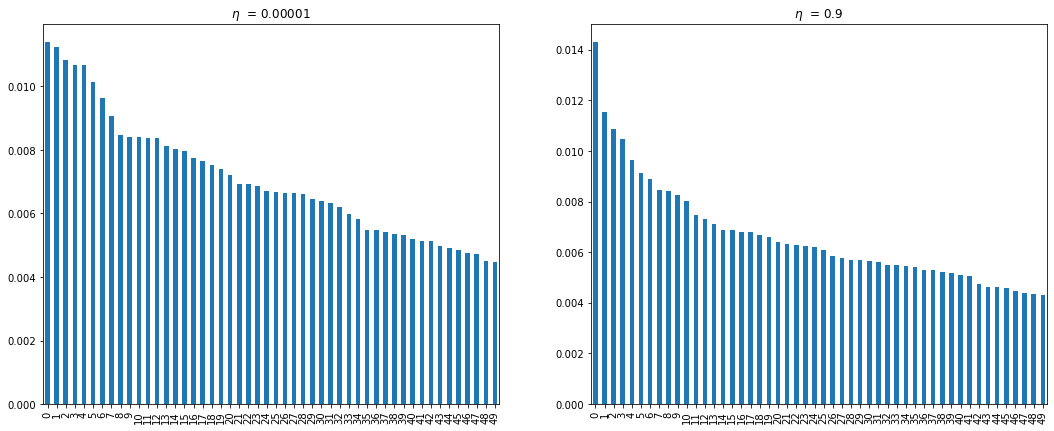

In [207]:
topic11_df = pandas.DataFrame(woslda1.show_topic(1, topn=50))
topic21_df = pandas.DataFrame(woslda2.show_topic(1, topn=50))

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)
topic11_df.plot.bar(legend = False, ax = ax1, title = '$\eta$  = 0.00001')
topic21_df.plot.bar(legend = False, ax = ax2, title = '$\eta$  = 0.9')
plt.show()

It looks like $\eta$ = 0.9 seems to be showing more smooth decrease in probability distribution of words as words get less important.

Finally, let's try the LDA model with 100 topics, instead of 4, and see the document-topic loading of first 10 articles:

In [235]:
woslda3 = gensim.models.ldamodel.LdaModel(corpus=wosmm, id2word=dictionary, num_topics=100, alpha='auto', eta='auto')

In [238]:
ldaDF3 

,name,topics
561874,Information Theoretic Complexity Affects Multi...,"[(15, 0.16007575), (21, 0.02909128), (27, 0.34..."
568360,The Practice Of Seclusion Among Patients Hospi...,"[(2, 0.073474966), (5, 0.3780853), (16, 0.0563..."
569371,Asymmetric Frontal Cortical Activity Predicts ...,"[(10, 0.39937308), (36, 0.18972646), (67, 0.06..."
566473,Autism Spectrum Disorder And Dsm-5: Spectrum O...,"[(17, 0.5093888), (18, 0.093075365), (37, 0.10..."
549316,"Attitudes Of Belgian Students Of Medicine, Phi...","[(26, 0.28708646), (60, 0.13324188), (81, 0.42..."
...,...,...
567744,Group Psychotherapy In Finland,"[(19, 0.28304937), (48, 0.4270363), (50, 0.150..."
565608,Patterns Of Modulation In The Activity And Con...,"[(0, 0.27836245), (19, 0.1255435), (34, 0.1760..."
578016,Mental Fatigue Impairs Emotion Regulation,"[(16, 0.019165093), (21, 0.03703302), (30, 0.2..."
561875,Looking Ahead? Computerized Maze Task Performa...,"[(10, 0.30248258), (32, 0.048725314), (60, 0.0..."


In [240]:
ldaDF3 = pandas.DataFrame({
        'name' : wos_df_['title'],
        'topics' : [woslda3[dictionary.doc2bow(l)] for l in wos_df_['reduced_tokens']]
    })

#Dict to temporally hold the probabilities
topicsProbDict3 = {i : [0] * len(ldaDF3) for i in range(woslda3.num_topics)}

#Load them into the dict
for index, topicTuples in enumerate(ldaDF3['topics']):
    for topicNum, prob in topicTuples:
        topicsProbDict3[topicNum][index] = prob

#Update the DataFrame
for topicNum in range(woslda3.num_topics):
    ldaDF3['topic_{}'.format(topicNum)] = topicsProbDict3[topicNum]

topicsDict3 = {}
for topicNum in range(woslda3.num_topics):
    topicWords = [w for w, p in woslda3.show_topic(topicNum)]
    topicsDict['Topic_{}'.format(topicNum)] = topicWords

wordRanksDF = pandas.DataFrame(topicsDict3)
wordRanksDF

ldaDFV3 = ldaDF3[:10][['topic_%d' %x for x in range(100)]]
ldaDFVisN3 = ldaDF3[:10][['name']]
ldaDFVis3 = ldaDFV3.to_numpy()
ldaDFVisNames3 = ldaDFVisN3.to_numpy()

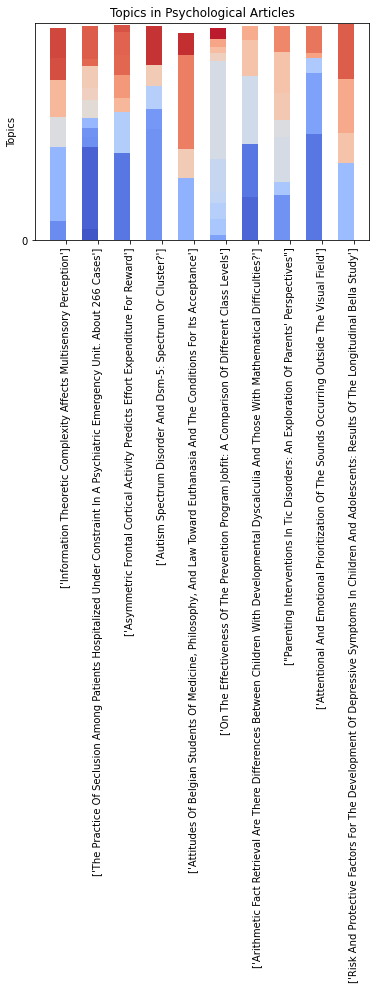

In [243]:
N = 10
ind = np.arange(N)
K = woslda3.num_topics  # N documents, K topics
ind = np.arange(N)  # the x-axis locations for the novels
width = 0.5  # the width of the bars
plots = []
height_cumulative = np.zeros(N)

for k in range(K):
    color = plt.cm.coolwarm(k/K, 1)
    if k == 0:
        p = plt.bar(ind, ldaDFVis3[:, k], width, color=color)
    else:
        p = plt.bar(ind, ldaDFVis3[:, k], width, bottom=height_cumulative, color=color)
    height_cumulative += ldaDFVis3[:, k]
    plots.append(p)
    

plt.ylim((0, 1))  # proportions sum to 1, so the height of the stacked bars is 1
plt.ylabel('Topics')

plt.title('Topics in Psychological Articles')
plt.xticks(ind+width/2, ldaDFVisNames, rotation='vertical')

plt.yticks(np.arange(0, 1, 10))
topic_labels = ['Topic #{}'.format(k) for k in range(K)]
#plt.legend([p[0] for p in plots], topic_labels, loc='center left', frameon=True,  bbox_to_anchor = (1, .5))

plt.show()

We can see that each article now contains diverse set of topics instead of containing one or two topics each! This is likely to be more representative of what articles are like: I feel like they are closer to a sum of little topics than a giant bulk of one or two topics in real life.

### Dynamic Topic Modelling



## <span style="color:red">*Exercise 4*</span>

<span style="color:red">Construct cells immediately below this that use topic models and networks, or dynamic topic models on datasets relevant to your final project. You can also extend the analysis of the COHA or Soap datasets, if relevant to the comparison of data for your projects. (You could possibly use coha_genres dictionary to conduct analysis on topic evolution for a particular genre? What themes do you see evolving throughout these corpora?)

I will try dynamic topic modeling, because my data span about 30 years.

Let's see the distribution of the number of articles first:

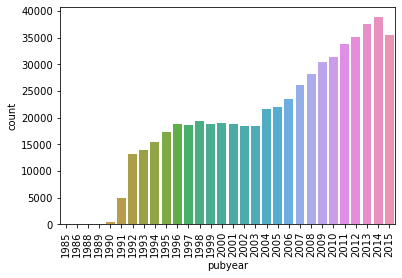

In [95]:
import seaborn as sns
sns.countplot(wos_df['pubyear'])
plt.xticks(rotation='vertical');

It looks like articles tagged as "psychology" are really sparse in Web of Science database before 1992. I will fit the model using 4 timeslices: [1992 - 2000, 2001 - 2005, 2006 - 2010, 2011 - 2015]. Let's first inspect the number of articles in each timeslice:

In [112]:
wos_df_time1 = wos_df[wos_df['pubyear'] <= 2000].copy()
wos_df_time1['time'] = 0
wos_df_time1.shape

(159901, 8)

In [113]:
wos_df_time2 = wos_df[(wos_df['pubyear'] > 2000) & (wos_df['pubyear'] <= 2005)].copy()
wos_df_time2['time'] = 1
wos_df_time2.shape

(99217, 8)

In [114]:
wos_df_time3 = wos_df[(wos_df['pubyear'] > 2005) & (wos_df['pubyear'] <= 2010)].copy()
wos_df_time3['time'] = 3
wos_df_time3.shape

(139425, 8)

In [115]:
wos_df_time4 = wos_df[(wos_df['pubyear'] > 2010) & (wos_df['pubyear'] <= 2015)].copy()
wos_df_time4['time'] = 4
wos_df_time4.shape

(180795, 8)

The quarter will probably end if I use all these data. I will randomly choose 1000 articles from each timeslice:

In [117]:
np.random.seed(513)
idx1 = np.random.choice(wos_df_time1.shape[0], size=1000, replace=False)
idx2 = np.random.choice(wos_df_time2.shape[0], size=1000, replace=False)
idx3 = np.random.choice(wos_df_time3.shape[0], size=1000, replace=False)
idx4 = np.random.choice(wos_df_time4.shape[0], size=1000, replace=False)
time_df = pandas.concat((wos_df_time1.iloc[idx1], wos_df_time2.iloc[idx2], wos_df_time3.iloc[idx3], wos_df_time4.iloc[idx4]))
time_df.shape

(4000, 8)

Tokenizing the texts:

In [120]:
time_df = time_df.loc[:, ['text', 'time']]
time_df['tokens'] = time_df['text'].apply(lucem_illud_2020.normalizeTokens)

I will use 4 topics for interpretability again.

Setting parameters and building dictionary and corpus:

In [128]:
docs_per_time_slice = [1000, 1000, 1000, 1000]
num_topics = 4

dictionary = gensim.corpora.Dictionary(corpus)
small_corpus = list(time_df['tokens'])
corpus = [dictionary.doc2bow(text) for text in small_corpus]

Fitting the model (this took about 15 hours - are there any way we can speed this up?)

In [131]:
ldaseq = ldaseqmodel.LdaSeqModel(corpus=corpus, id2word=dictionary, time_slice=docs_per_time_slice, num_topics=num_topics)

C:\Users\nousl\Anaconda3\envs\macs60000\lib\site-packages\gensim\models\ldaseqmodel.py:293: RuntimeWarning: divide by zero encountered in double_scalars
  convergence = np.fabs((bound - old_bound) / old_bound)


In [132]:
ldaseq.save("ldaseqmodel_small")

I will store the topics in each timeslice as dataframe.

In [139]:
ldaseq_topics = pandas.DataFrame()
for topic in range(num_topics):
    for time in range(len(docs_per_time_slice)):
        s = f'topic{topic}_time{time}'
        ldaseq_topics[s] = list(ldaseq.dtm_coherence(time)[topic])

Let's look at how the top words for topics 0 and 1 changed over the 4 timeslices:

In [141]:
ldaseq_topics.iloc[:, :8]

,topic0_time0,topic0_time1,topic0_time2,topic0_time3,topic1_time0,topic1_time1,topic1_time2,topic1_time3
0,disorder,disorder,disorder,study,child,child,child,child
1,patient,study,study,disorder,study,study,study,study
2,study,patient,patient,patient,social,social,social,social
3,treatment,treatment,treatment,treatment,self,self,self,self
4,group,group,health,health,student,student,student,student
5,health,health,symptom,symptom,behavior,behavior,behavior,behavior
6,report,symptom,group,report,relationship,relationship,relationship,relationship
7,use,report,report,group,factor,factor,high,factor
8,symptom,use,use,use,high,high,factor,high
9,result,result,result,result,group,group,group,group


It looks like topic_0 is related to clincial psychology and mental health problem in general, and topic_1 is broadly related to developmental psychology and social/personality psychology. We see that the top words change positions as time progresses, but there does not seem to be a substantive difference.

Now let's look at topic 2 and 3:

In [142]:
ldaseq_topics.iloc[:, 8:]

,topic2_time0,topic2_time1,topic2_time2,topic2_time3,topic3_time0,topic3_time1,topic3_time2,topic3_time3
0,process,process,process,process,response,response,effect,effect
1,task,task,task,task,effect,effect,response,response
2,study,study,study,study,stimulus,stimulus,stimulus,stimulus
3,memory,memory,memory,memory,condition,condition,condition,condition
4,effect,effect,effect,effect,group,group,group,group
5,learn,learn,learn,learn,experiment,experiment,result,result
6,model,model,model,result,result,result,experiment,task
7,result,result,result,model,task,task,task,experiment
8,word,word,word,word,test,test,test,test
9,information,information,information,cognitive,subject,study,study,study


Looks like the topic 2 is related to cognitive psychology and topic 3 is related to very classical behavioral psychology. Again, there is some fluctuation in the order of top words, but there does not seems to be a substantive difference.

Finally, let's see the how the proportion of each topic changed over time. If I am correct about labeling topic_3 as classical behavioral psychology, we should see a decrease in the proportion of topic_3 as time goes on. (the visualization was largely helped by Mint or Wanitchaya Poonpatanapritcha)

In [143]:
vis = ldaseq.dtm_vis(time=0,corpus=corpus)[0]

In [157]:
vis_df = pandas.DataFrame()
for t in range(len(docs_per_time_slice)):
    new = pandas.DataFrame(vis[1000 * t:1000 * (t + 1)].mean(axis = 0))
    new['time'] = t
    vis_df = vis_df.append(new)
vis_df['topic'] = vis_df.index
vis_df = vis_df.rename(columns={0:'proportion'})

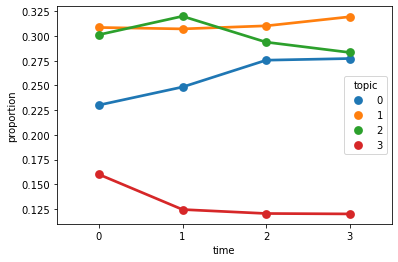

In [160]:
sns.pointplot(data = vis_df, x = 'time', y = "proportion", hue = 'topic')

Indeed, we see decline of topic_3 as timeslice moves from 0 to 1. Topic 0, which I labeled as clinical psychology and mental health problems, seems to be having a quite steady increase in the overall proportion.

Finally, I tried out some visualalization using `pyLDAvis` package which Bhargav used in his sample code for `ldaseqmodel`:

In [146]:
doc_topic, topic_term, doc_lengths, term_frequency, vocab = ldaseq.dtm_vis(time=0, corpus=corpus)
vis_dtm = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency)
pyLDAvis.display(vis_dtm)

In [147]:
doc_topic, topic_term, doc_lengths, term_frequency, vocab = ldaseq.dtm_vis(time=3, corpus=corpus)
vis_dtm = pyLDAvis.prepare(topic_term_dists=topic_term, doc_topic_dists=doc_topic, doc_lengths=doc_lengths, vocab=vocab, term_frequency=term_frequency)
pyLDAvis.display(vis_dtm)

We can see that the topic clusters are quite segregated and distinct from each other. This again suggest that we might want to try more number of clusters.